# Computer Vision

In [4]:
import torch # библиотека машинного обучения
import torchvision # библиотека для работы с CV
import pickle # сериализация, загрузка и сохранение переменных
import numpy as np
# import tarfile 
from torchvision import transforms # библиотека для аугментации (преобразования изображений)
import matplotlib.pyplot as plt
import torch.nn as nn # работа со слоями нейроседля создания слоев нейронной сети, функций активации, функций потерь и других компонентов нейронной сети

## Task 1

Давай загрузим датасет CIFAR-10. Допиши функцию [load_dataloaders](./code-samples/cv_utils.py) с помощью [torchvision.datasets.CIFAR10](https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html)
и [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader), чтобы функция возвращала
DataLoaderы для train и test частей датасета. \
C помощью функции `len` количество батчей в train_loader и test_loader.
> Для DataLoader параметры `transform` и `batch_size` оставьте по умолчанию.

In [5]:
# Определяем объект BASE_TRANSFORM для создания последовательности преобразований для обработки изображений.
BASE_TRANSFORM = transforms.Compose(
    [
        # Перевод изображений в тензоры
        transforms.ToTensor(),
        # Переводим цвета пикселей в отрезок [-1, 1]
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)
BATCH_SIZE = 64 # Количество изображений в Батче
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # Классы CIFAR10

In [6]:
# Создаем загрузчики данных для обучения и тестирования модели на датасете CIFAR10. 
def load_dataloaders(transform=BASE_TRANSFORM, batch_size=BATCH_SIZE):
    train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return train_loader, test_loader

train_loader, test_loader = load_dataloaders()
print(len(train_loader))
print(len(test_loader))

100%|████████████████████████| 170498071/170498071 [00:53<00:00, 3189578.59it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
782
157


## Task 2

Узнай, как из объекта DataLoader можно получить изображения и метки. \
Передай первые 4 изображения и метки из первого батча тестовой выборки в функцию [imshow](./code-samples/cv_utils.py).
С помощью нее можно визуализировать датасет. \
Должна получиться примерно такая визуализация.
![sample](../datasets/images_sample.png)
> Картинки и метки могут отличаться. Главное чтобы метки сходились с изображениями)

In [7]:
# отображаем изображения и соответствующие им метки классов в виде графического изображения. 
def imshow(images, labels, padding_size=15, labels_split_size=25):
    # убрать нормализацию
    images = images / 2 + 0.5    
    npimg = images.numpy()
    label_text = (' ' * labels_split_size).join('{}'.format(CLASSES[j]) for j in labels.tolist())
    print(' ' * padding_size + label_text)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

               cat                         ship                         ship                         plane


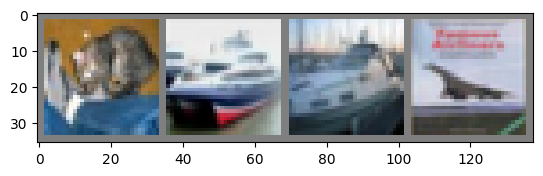

In [8]:
# Получаем первый батч тестовой выборки
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Визуализируем первые 4 изображения и метки
imshow(torchvision.utils.make_grid(images[:4]), labels[:4])


## Task 3

Теперь попробуем написать небольшую сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Напишем сеть, основанную на одном блоке архитектуры [ResNet](https://arxiv.org/pdf/1512.03385.pdf) - Residual-Block. Схема этого блока приведена ниже:

<img src="../datasets/rediual_block.png" width="500"/>

Допишите класс ResidualNet:
- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Также в сверточных слоях `padding = 1`

Функции, которые вам понадобяться: 
[Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html), [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html).

Для базовой проверки, что сеть написана верно этот код не должен выдавать ошибку\
`assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)`

In [13]:
# Создаем модель нейронной сети
class ResidualNet(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()

        self.conv_3 = nn.Conv2d(3, 32, 1) # сверточный слой с ядром размера 1x1, кот. преобразует входное изображение с 3 каналами в изображение с 32 каналами

        self.residual_block = nn.Sequential( # последовательность слоев, кот. реализует остаточный блок. Он состоит из двух сверточных слоев с ядром размера 3x3 и 32 выходными каналами, слоя нормализации по батчу и функции активации ReLU
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32)
        )

        self.clf = nn.Sequential( # последовательность слоев, которая реализует классификатор. Он состоит из функции активации ReLU, слоя пулинга по среднему значению, слоя выравнивания, который преобразует многомерный тензор в одномерный, и полносвязного слоя, который преобразует выходные данные в соответствии с заданным количеством классов.
            nn.ReLU(),
            nn.AvgPool2d(8),
            nn.Flatten(1),
            nn.Linear(512, n_classes)
        )

    def forward(self, x): # Метод forward принимает входной тензор x и пропускает его через остаточный блок и классификатор. Результат возвращается в качестве выходного тензора.

        out = self.residual_block(x)
        out += self.conv_3(x)
        out = self.clf(out)

        return out

In [14]:
# проверка
net = ResidualNet()
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

## Task 4

Перейдем к обучению сети. В этом вам поможет класс [Trainer](./code-samples/cv_utils.py).\
Для обучения кроме самой модели 
требуемся определить оптимизатор и функцию ошибок:
* В качестве оптимизатора выберите [стохастический градиентный спуск](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)
* В качестве функции ошибок
[кросс-энтропия](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

Обучите сеть и с помощью функции [plot_train_log](./code-samples/cv_utils.py) визуализируй процесс обучения модели.

In [15]:
# определение класса Trainer, кот. предназначен для обучения нейронной сети на основе заданных параметров и данных
class Trainer:
    
    def __init__(self, model, optimizer, criterion): # определяем параметры обучения, такие как модель (model), оптимизатор (optimizer) и функция потерь (criterion)
        self.model = model
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.model = self.model.to(self.device)
        print('Сеть загружена на', self.device)
        
        self.optimizer = optimizer
        self.criterion = criterion

    def _train_epoch(self, train_loader): # обучаем модель на одной эпохе и возвращаем среднее значение потерь и точности на обучающей выборке
        loss_log = []
        acc_log = []
        self.model.train()

        for data, target in train_loader:
            data = data.to(self.device)
            target = target.to(self.device)

            self.optimizer.zero_grad()
            logits = self.model(data)

            loss = self.criterion(logits, target)
            loss.backward()
            self.optimizer.step()

            loss_log.append(loss.item() * data.shape[0])

            acc = (logits.argmax(dim=1) == target).sum()
            acc_log.append(acc.item() / data.shape[0]) 

        return np.mean(loss_log), np.mean(acc_log)

    def train(self, train_loader, test_loader, n_epochs): # обучаем модель на заданном количестве эпох, сохраняя значения потерь и точности на обучающей и тестовой выборках
        
        self.train_loss_log = [] 
        self.train_acc_log = [] 
        self.test_loss_log = []
        self.test_acc_log = []
        
        for epoch in range(n_epochs):
            train_loss, train_acc = self._train_epoch(train_loader)
            test_loss, test_acc = self.test(test_loader)

            self.train_loss_log.append(train_loss)
            self.train_acc_log.append(train_acc)

            self.test_loss_log.append(test_loss)
            self.test_acc_log.append(test_acc)

            print(f"Epoch {epoch}")
            print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
            print(f" test loss: {test_loss}, test acc: {test_acc}\n")
    
    def test(self, test_loader): #  тестируем модель на тестовой выборке и возвращаем среднее значение потерь и точности.
        loss_log = []
        acc_log = []
        self.model.eval()

        for data, target in test_loader:
            data = data.to(self.device)
            target = target.to(self.device)

            with torch.no_grad():
                logits = self.model(data)
                loss = self.criterion(logits, target)

            loss_log.append(loss.item() * data.shape[0])

            acc = (logits.argmax(dim=1) == target).sum()
            acc_log.append(acc.item() / data.shape[0]) 

        return np.mean(loss_log), np.mean(acc_log)

In [16]:
# определяем функцию, кот. принимает объект trainer и строим графики изменения функции потерь и точности на обучающей и тестовой выборках в зависимости от количества эпох обучения. Графики отображаются на одном рисунке с двумя подграфиками: слева - график функции потерь, справа - график точности. Каждый график содержит две кривые: для обучающей и тестовой выборок.
def plot_train_log(trainer):
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))

    axs[0].plot(range(1, len(trainer.train_loss_log) + 1), trainer.train_loss_log, label='train')
    axs[0].plot(range(1, len(trainer.test_loss_log) + 1), trainer.test_loss_log, label='test')
    axs[0].set_ylabel('Loss')

    axs[1].plot(range(1, len(trainer.train_acc_log) + 1), trainer.train_acc_log, label='train')
    axs[1].plot(range(1, len(trainer.test_acc_log) + 1), trainer.test_acc_log, label='test')
    axs[1].set_ylabel('Accuracy')

    for ax in axs:
        ax.set_xlabel('Epoch')
        ax.legend()

    plt.show()

In [17]:
# создаем модель ResidualNet, определяем оптимизатор SGD с learning rate 0.01 и функцию потерь CrossEntropyLoss
model = ResidualNet()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [18]:
# обучаем модель на тренировочных данных, используя оптимизатор и функцию потерь, и вычисляем значения потерь и точности на тренировочных и тестовых данных на каждой эпохе.
trainer = Trainer(model, optimizer, criterion)
trainer.train(train_loader, test_loader, n_epochs=12)

Сеть загружена на cpu
Epoch 0
 train loss: 110.93300006700599, train acc: 0.3929427749360614
 test loss: 95.11867981200005, test acc: 0.4793988853503185

Epoch 1
 train loss: 91.4770108171741, train acc: 0.4952645460358056
 test loss: 87.34520435940688, test acc: 0.5146297770700637

Epoch 2
 train loss: 85.41704613717316, train acc: 0.530071131713555
 test loss: 84.08868302509283, test acc: 0.5353304140127388

Epoch 3
 train loss: 81.66332636220986, train acc: 0.5515105498721228
 test loss: 79.63725228522235, test acc: 0.5601114649681529

Epoch 4
 train loss: 78.28900796739036, train acc: 0.5713914641943734
 test loss: 75.58742124715428, test acc: 0.585390127388535

Epoch 5
 train loss: 75.07163980976699, train acc: 0.587176310741688
 test loss: 73.2073668947645, test acc: 0.5969347133757962

Epoch 6
 train loss: 71.8637238182985, train acc: 0.6086756713554987
 test loss: 74.3180064304619, test acc: 0.5861863057324841

Epoch 7
 train loss: 68.79170968770372, train acc: 0.62370124680306

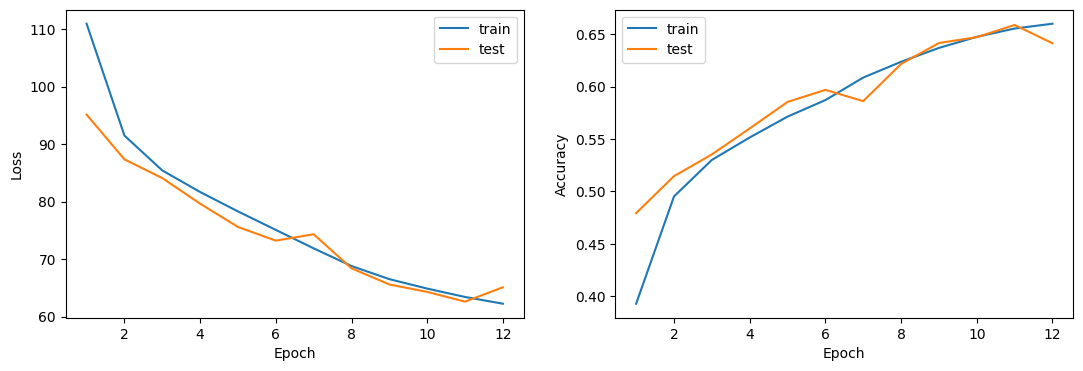

In [19]:
plot_train_log(trainer)

## Task 5

Одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. \
Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки,  тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.
Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке `transforms`, который затем передается в Dataloader.\
Изучи, какие [способы аугментаций](https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py) 
изображений можно использовать PyTorch. Выберите несколько из них и визуализируйте как изменился датасет. 
![sample](../datasets/images_sample.png)
![sample](../datasets/augment.png)

Обучите сеть с аугментацией данных и с помощью функции [plot_train_log](./code-samples/cv_utils.py) визуализируй процесс обучения модели.

               cat                         ship                         ship                         plane


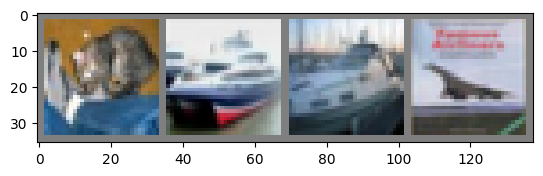

In [20]:
imshow(torchvision.utils.make_grid(images[:4]), labels[:4])

Files already downloaded and verified
Files already downloaded and verified
               cat                         ship                         ship                         plane


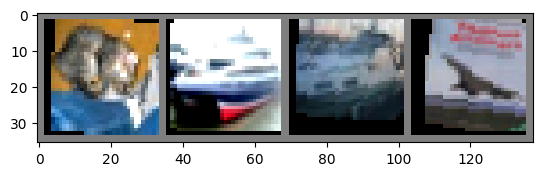

In [21]:
# Пример аугментации данных
transform_v2 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomCrop(size=(32, 32), padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Загружаем данные с новой аугментацией
train_loader_v2, test_loader_v2 = load_dataloaders(transform=transform_v2)

# Визуализируем первые 4 изображения из новой выборки
dataiter_v2 = iter(test_loader_v2)
images_v2, labels_v2 = next(dataiter_v2)
imshow(torchvision.utils.make_grid(images_v2[:4]), labels_v2[:4])

In [22]:
# Обучаем модель
model = ResidualNet()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, criterion)
trainer.train(train_loader, test_loader, n_epochs=12)

Сеть загружена на cpu
Epoch 0
 train loss: 110.09290452503487, train acc: 0.3963794757033248
 test loss: 94.935275436207, test acc: 0.46526671974522293

Epoch 1
 train loss: 91.0135949298244, train acc: 0.5008192135549873
 test loss: 86.53522970114544, test acc: 0.5211982484076433

Epoch 2
 train loss: 84.642492444314, train acc: 0.5380035166240409
 test loss: 81.25305911993524, test acc: 0.5474721337579618

Epoch 3
 train loss: 79.89988952402568, train acc: 0.5633591751918159
 test loss: 77.52285008521596, test acc: 0.5709593949044586

Epoch 4
 train loss: 76.67430261821698, train acc: 0.5800631393861893
 test loss: 76.44308163102265, test acc: 0.5796178343949044

Epoch 5
 train loss: 73.95044981427205, train acc: 0.5962476023017903
 test loss: 72.05216139289224, test acc: 0.6025079617834395

Epoch 6
 train loss: 71.69812437823362, train acc: 0.6090752877237852
 test loss: 70.21978798641521, test acc: 0.609375

Epoch 7
 train loss: 69.90832890756904, train acc: 0.6199648337595908
 tes

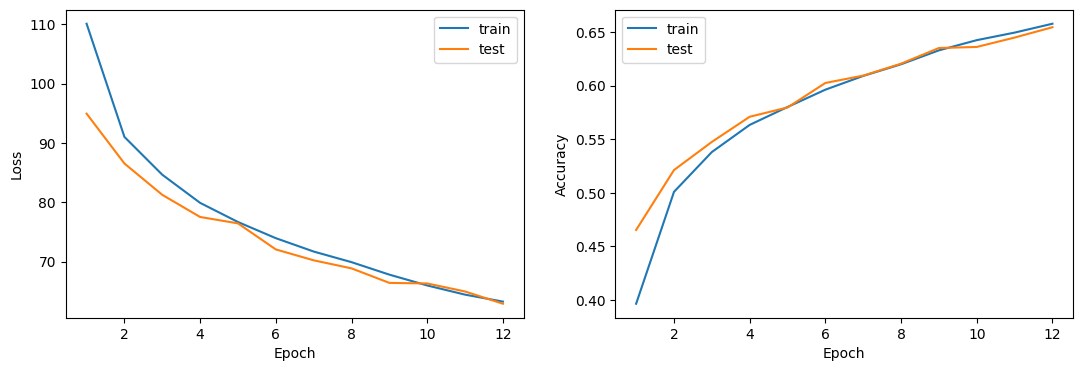

In [23]:
# Визуализируем процесс обучения
plot_train_log(trainer)